In [5]:
from preprocessing import *
import pandas as pd
import os
from fst4conll import *
from conll import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
%%bash
dpath='NL2SparQL4NLU/dataset/NL2SparQL4NLU'
spath='dataset'
mkdir -p $spath

cp $dpath.train.utterances.txt $spath/trn.txt
cp $dpath.test.utterances.txt $spath/tst.txt

cp $dpath.train.conll.txt $spath/trn.conll
cp $dpath.test.conll.txt $spath/tst.conll

## Joint Distribution Modeling

In [7]:
#generate files
if not os.path.exists('JointDist'):
    os.makedirs('JointDist')
    
trn = read_corpus_conll('dataset/trn.conll')
wt_sents = [["+".join(w) for w in s] for s in trn]
tf_min = 1
wt_osyms,out = cutoff(wt_sents,tf_min)

wt_isyms = [w.split('+')[0] for w in wt_osyms]

with open('JointDist/trn.wt.txt', 'w') as f:
    for s in wt_sents:
        f.write(" ".join(s) + "\n")
        
with open('JointDist/osyms.wt.lst.txt', 'w') as f:
    f.write("\n".join(wt_osyms) + "\n")
    
with open('JointDist/isyms.wt.lst.txt', 'w') as f:
    f.write("\n".join(wt_isyms) + "\n")

In [8]:
%%bash
#make input/output lexicons
bpath='JointDist'
ngramsymbols $bpath/osyms.wt.lst.txt $bpath/osyms.wt.txt
ngramsymbols $bpath/isyms.wt.lst.txt $bpath/isyms.wt.txt

rm $bpath/osyms.wt.lst.txt
rm $bpath/isyms.wt.lst.txt

## Create Lexicon

In [9]:
%%bash 
#use lexicons with both cutoff
bpath='JointDist'
cat $bpath/isyms.wt.txt $bpath/osyms.wt.txt | cut -f 1 | sort | uniq > $bpath/lex.lst.txt
ngramsymbols $bpath/lex.lst.txt $bpath/lex.txt
rm $bpath/lex.lst.txt

## Extract test sentences

In [6]:
%%bash
farcompilestrings \
    --symbols=JointDist/lex.txt \
    --keep_symbols \
    --unknown_symbol='<unk>' \
    dataset/tst.txt tst.far

wdir='JointDist/wdir'
mkdir -p 'JointDist/wdir'
farextract --filename_prefix="$wdir/" tst.far

rm tst.far

## Create W2WT FST

In [7]:
def make_w2t_wt(isyms, sep='+', out='w2wt.tmp'):
    special = {'<epsilon>', '<s>', '</s>'}
    oov = '<unk>'  # unknown symbol
    state = '0'    # wfst specification state
    fs = " "       # wfst specification column separator
    
    ist = sorted(list(set([line.strip().split("\t")[0] for line in open(isyms, 'r')]) - special))
    
    with open(out, 'w') as f:
        for e in ist:
            f.write(fs.join([state, state, e.split('+')[0], e]) + "\n")
        if tf_min<2:
            for e in ist:
                f.write(fs.join([state, state, oov, e]) + "\n")  
        f.write(state + "\n")

In [8]:
make_w2t_wt('JointDist/osyms.wt.txt', out='JointDist/w2wt_wt.txt')

In [1]:
%%bash
# Let's compile it
fstcompile \
    --isymbols=JointDist/lex.txt \
    --osymbols=JointDist/lex.txt \
    --keep_isymbols \
    --keep_osymbols \
    JointDist/w2wt_wt.txt | fstarcsort - > JointDist/w2wt_wt.bin
    
fstinfo JointDist/w2wt_wt.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                JointDist/lex.txt
output symbol table                               JointDist/lex.txt
# of states                                       1
# of arcs                                         4520
initial state                                     0
# of final states                                 1


## Create language models

In [11]:
%%bash
#CREATE LANGUAGE MODELS
mkdir -p 'JointDist/models'
lmpath='JointDist/models'
bpath='JointDist/'
for ngram in 1 2 3 4 5
do
    for smooth in "absolute" "witten_bell" "kneser_ney" "katz" "presmoothed" "unsmoothed"
    do
        farcompilestrings --symbols=$bpath/lex.txt --keep_symbols \
                          --unknown_symbol='<unk>' $bpath/trn.wt.txt $bpath/trn.far
        ngramcount --order=$ngram $bpath/trn.far $bpath/trn.cnt
        ngrammake --method=$smooth $bpath/trn.cnt $lmpath/$smooth.$ngram.lm
        rm $bpath/trn.cnt
        rm $bpath/trn.far
    done
done

## Test on one sentence

In [11]:
%%bash
##TEST
wdir='JointDist/wdir'

cp $wdir/tst.txt-0009 sent.fsa

fstprint --isymbols=JointDist/lex.txt --osymbols=JointDist/lex.txt sent.fsa

fstcompose sent.fsa JointDist/w2wt_wt.bin |\
fstcompose - JointDist/models/absolute.2.lm |\
fstshortestpath | fstrmepsilon | fsttopsort |\
fstprint --isymbols=JointDist/lex.txt

0	1	cast	cast
1	2	and	and
2	3	crew	crew
3	4	for	for
4	5	in	in
5	6	july	july
6
0	1	cast	cast+O	5.74118996
1	2	and	and+O	0.601551354
2	3	crew	crew+O	0.660670996
3	4	for	for+O	0.737131655
4	5	in	in+B-movie.name	4.26451397
5	6	july	july+I-movie.name	0.215878397
6	0.245315641


## Loop on test set

In [12]:
%%bash
wdir='JointDist/wdir'
farr=($(ls $wdir))
mkdir -p 'JointDist/result'
mkdir -p 'JointDist/scores'
rpath='JointDist/result'

for ngo in 1 2 3 4 5
do
    for lm in "absolute" "witten_bell" "kneser_ney" "katz" "presmoothed" "unsmoothed"
    do
        for f in ${farr[@]}
        do
            fstcompose $wdir/$f JointDist/w2wt_wt.bin |\
            fstcompose - JointDist/models/$lm.$ngo.lm |\
            fstshortestpath | fstrmepsilon | fsttopsort |\
            fstprint --isymbols=JointDist/lex.txt
        done > $rpath/pred.$lm.$ngo.txt
    done
done

## Evaluation

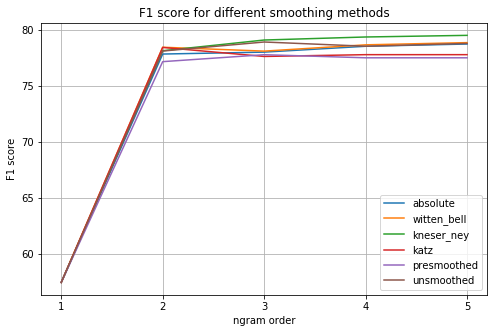

cutoff:  1
           0          1          2          3          4
0  57.441253  77.823503  77.993674  78.516508  78.716674
1  57.441253  78.431373  78.084049  78.645598  78.842676
2  57.441253  78.117862  79.073990  79.344859  79.490678
3  57.441253  78.411684  77.607914  77.767777  77.767777
4  57.441253  77.144140  77.762983  77.487837  77.487837
5  57.441253  78.090909  78.897424  78.519856  78.771454


In [13]:
ngrams = [1,2,3,4,5]
smoothing_methods = ["absolute", "witten_bell", "kneser_ney", "katz", "presmoothed", "unsmoothed"]
f1scores = []

with open("JointDist/scores/cf{}.txt".format(tf_min), 'w') as f:
    f.write("Cutoff: {}\n".format(tf_min))               
    for sm in smoothing_methods:
        sms = []    
        f.write("Smoothing method: {}\n".format(sm))
        for ngo in ngrams:

            refs = read_corpus_conll('dataset/tst.conll')
            hyps = read_fst4conll('JointDist/result/pred.'+sm+'.'+str(ngo)+'.txt', split=True)
            results = evaluate(refs, hyps)
        
            pd_tbl = pd.DataFrame().from_dict(results, orient='index').iloc[-1:]
            val = pd.DataFrame().from_dict(results, orient='index').iloc[-1,pd_tbl.columns.get_loc('f')]*100
            sms.append(val)
            f.write("{}: {}\t".format(ngo,round(val,3)))

        f1scores.append(sms)
        f.write("\n")

#------------------PLOT---------------------
plt.figure(figsize=(8,5))
for sm in range(len(smoothing_methods)):
    plt.plot(ngrams,f1scores[sm], label=smoothing_methods[sm])
plt.title("F1 score for different smoothing methods")
plt.xlabel("ngram order")
plt.ylabel("F1 score")
plt.legend(loc='best')
plt.xticks(ngrams)
plt.grid()
plt.show()

print("cutoff: ",tf_min)
print(pd.DataFrame(f1scores))